In [1]:
## anaconda3 (Python 3.12.0) Kernel
# pair trade packages
import csv
import gym
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from datetime import datetime
# nn packages
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
from collections import Counter
from torch.utils.data import DataLoader, WeightedRandomSampler

def custom_date_parser(date_str):
    return datetime.strptime(date_str, '%d/%m/%Y')
# Load the dictionary from the pickle file
with open('pairsOutcome.pkl', 'rb') as file:
    pairsOutcome = pickle.load(file)
# Load stock data and get return 
tpxData = pd.read_csv('TPX_prices.csv', index_col=0, parse_dates=True, date_parser=custom_date_parser)
tpxData = tpxData.dropna(axis='columns')
return_df = (tpxData / tpxData.shift(1)) - 1

/var/folders/h2/r7qn2m9n1zb6y_0q191gdqth0000gn/T/ipykernel_13654/1916853760.py:27: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  tpxData = pd.read_csv('TPX_prices.csv', index_col=0, parse_dates=True, date_parser=custom_date_parser)


# Load Pairs Data


# Get Pair Trade Portfolio
`pairsOutcome` already have TOPIX stocks with highest liquidity and are tested for stationarity over a 1 year window

Choose top 10 known pair trades by returns in the total dataset

In [2]:
with open("output_clustering.csv", 'r') as csvfile:
    reader = csv.reader(csvfile)
    # Skip the header row
    next(reader)
    working_pairs = [tuple(row) for row in reader]

top_keys = [f"{pair[0]} {pair[1]}" for pair in working_pairs]
print("Top 10 clustered trades:")
for i, key in enumerate(top_keys, 1):
    print(f"{i}. Key: {key}, Return: {pairsOutcome[key].cumpnl.iloc[-2]:.2f}")

Top 10 clustered trades:
1. Key: 6503 JP Equity 7269 JP Equity, Return: 1.33
2. Key: 6326 JP Equity 6954 JP Equity, Return: 1.19
3. Key: 8053 JP Equity 8058 JP Equity, Return: 0.52
4. Key: 4901 JP Equity 9613 JP Equity, Return: 1.10
5. Key: 6988 JP Equity 7267 JP Equity, Return: 0.65
6. Key: 4901 JP Equity 6702 JP Equity, Return: -0.34
7. Key: 4684 JP Equity 7832 JP Equity, Return: 0.89
8. Key: 7267 JP Equity 8306 JP Equity, Return: 1.16
9. Key: 7267 JP Equity 8801 JP Equity, Return: 0.64
10. Key: 4519 JP Equity 7532 JP Equity, Return: 1.14


In [3]:
valid = pd.read_csv('validPairs5.csv', 
                    index_col=0, 
                    parse_dates=True, 
                    date_parser=custom_date_parser)
## get list of pair stocks
validPairsList = [
    [item.strip() + ' Equity' for item in pair.split('Equity') if item.strip()]
    for pair in top_keys
]

/var/folders/h2/r7qn2m9n1zb6y_0q191gdqth0000gn/T/ipykernel_13654/4194707529.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  valid = pd.read_csv('validPairs5.csv',


# Machine Learning Challenge

## Background
Initial evaluation of the baseline portfolio shows that draw downs are small. Originally team had the idea of using Machine Learning to optimise for sizing of these pair trades. However since there was no significant drawdowns the returns are linearly increasing with investment sizing i.e. greater nominal investment in the the pair trade the proportionate increase in returns without realising significant drawdown risk.

Instead of optimising for sizing, we can explore Machine Learning in terms of strategy on this stationary dataset. Whereas our prescribed strategy is to enter at +/- 1 std dev, exit at 0 with +/- 2 std dev stop loss. These are only suggestions and arbitrary levels.

With Machine Learning, we can discover if it will uncover the mean reverting nature and recommend another threshhold. We use Q Learner to understand state space with the same spread, mid, std dev parameters as the baseline.

### Steps
#### Environment:
- State Space: A set of all possible states the agent can be in.  
  - [spread, mid, 2 sd low, 1 sd low, 1 sd high, 2 sd high]
- Action Space: A set of all possible actions the agent can take in each state.   
  - [-1, # short\
      0, # uninvested\
      1  # long]   
- Reward Function: A function that assigns a numerical reward to each state-action pair, indicating the immediate consequence of taking a particular action in a specific state.
  - dailypnl
- Transition Function: A function that determines the probability of transitioning from one state to another when a particular action is taken.
  - deterministic based on historical performance
#### Agent:

- Q-Table: A matrix that stores the estimated Q-values for each state-action pair. Q-values represent the expected future reward for taking a specific action in a given state.   
  - continuous Q table?
- Learning Rate (α): A parameter that controls how much the Q-values are updated with each new experience.   
- Discount Factor (γ): A parameter that determines the importance of future rewards. A higher discount factor gives more weight to future rewards.   
- Exploration Rate (ε): A parameter that controls the balance between exploration (trying new actions) and exploitation (choosing the action with the highest Q-value).   
- Q-Learning Algorithm:

  - Initialization: Initialize the Q-table with random values or zeros.   
  - Exploration and Exploitation: Use an exploration strategy (e.g., ε-greedy) to choose an action:
    - With probability ε, choose a random action.   
    - With probability 1-ε, choose the action with the highest Q-value for the current state.   
  
  - Take Action: Execute the chosen action in the environment.   
  - Observe Reward and Next State: Observe the immediate reward and the next state resulting from the action.
- Update Q-Value: Update the Q-value of the current state-action pair using the following formula:

## Make indicators and spread stationary around 0
Deduct the mean from all values to translate to 0 axis

#### Training and Test set

2013 is used for warm start\
2014 - 2023 train data since NN need a lot of training data {end 2023 idx == 2868}\
2024 onwards (5 months) test data


In [4]:
rollingWindow = 262
cutLossSd = 2

for pair in validPairsList:
    df = pd.DataFrame()

    #Calculate Standard Deviations
    df['spread'] = valid[f'spread_{pair[0]}_{pair[1]}']
    df['mid'] =  df['spread'].rolling(rollingWindow).mean()
    df['1sd high'] = df['spread'].rolling(rollingWindow).mean() + df['spread'].rolling(rollingWindow).std()
    df['1sd low'] = df['spread'].rolling(rollingWindow).mean() - df['spread'].rolling(rollingWindow).std()
    df['2sd high'] = df['spread'].rolling(rollingWindow).mean() + df['spread'].rolling(rollingWindow).std() * cutLossSd
    df['2sd low'] = df['spread'].rolling(rollingWindow).mean() - df['spread'].rolling(rollingWindow).std() * cutLossSd
    df['position'] = 0

    df.loc[(df['spread'] > df['1sd high']) & (df['spread'] < df['2sd high']), 'position'] = -1
    df.loc[(df['spread']< df['1sd low']) & (df['spread'] > df['2sd low']), 'position'] = 1

    #Calculate PnL
    df[f'{pair[0]} position'] = df['position']
    df[f'{pair[1]} position'] = df['position'] * -1
    df['dailypnl'] = df[f'{pair[1]} position']*return_df[f'{pair[1]}'].shift(-1) + df[f'{pair[0]} position']*return_df[f'{pair[0]}'].shift(-1)
    df['cumpnl'] = df['dailypnl'].cumsum()

    pairsOutcome[f'{pair[0]} {pair[1]}'] = df

workingPairOutcome = {}

for pair in top_keys:
    dummy_df = pairsOutcome[top_keys[0]].iloc[::,:6]
    dummy_df = dummy_df.subtract(dummy_df['mid'], axis=0).drop(columns=['mid']) # centre spread and SD
    dummy_df = dummy_df.div(dummy_df['2sd high']-dummy_df['1sd high'],axis=0)   # express SD as integers, give spread as propotionate
    dummy_df['2sd_high_boolean'] = (dummy_df['spread']>dummy_df['2sd high']).astype(int)
    dummy_df['1sd_high_boolean'] = (dummy_df['spread']>dummy_df['1sd high']).astype(int)
    dummy_df['0sd_high_boolean'] = (dummy_df['spread']>0).astype(int)
    dummy_df['0sd_low_boolean']  = (dummy_df['spread']<0).astype(int)
    dummy_df['1sd_low_boolean']  = (dummy_df['spread']<dummy_df['1sd low'] ).astype(int)
    dummy_df['2sd_low_boolean']  = (dummy_df['spread']<dummy_df['2sd low'] ).astype(int)
    dummy_df = dummy_df.drop(columns=['1sd high', '1sd low', '2sd high', '2sd low'])
    workingPairOutcome[pair] = dummy_df.to_numpy()

workingPairOutcome[top_keys[5]][-5:]  

array([[1.9241356 , 0.        , 1.        , 1.        , 0.        ,
        0.        , 0.        ],
       [1.98850523, 0.        , 1.        , 1.        , 0.        ,
        0.        , 0.        ],
       [1.43802272, 0.        , 1.        , 1.        , 0.        ,
        0.        , 0.        ],
       [1.04480167, 0.        , 1.        , 1.        , 0.        ,
        0.        , 0.        ],
       [1.55025067, 0.        , 1.        , 1.        , 0.        ,
        0.        , 0.        ]])

- Test one timestep at a time (even though we can test all at the same time)
- give state
- Trading should be path dependent due to stop loss. in this case I can only give last position as one of the parameters

In [5]:
class PairTradeEnv(gym.Env):
    # ... (define your environment's state space, action space, etc.)
    def __init__(self, workingPairOutcome, top_keys, validPairsList, return_df):
        # ... (initialize other parameters)
        self.earliest_step = 261  # hot start
        self.last_step = 2868
        # self.current_step = random.randint(self.earliest_step, self.last_step - 1)
        self.current_step = self.earliest_step


    def step(self, action, pair_idx):
        """
        Input
            action: single value e.g. -1 (short)
            pair_idx: index of pair trade
        Output:
            next_state: next state 
            reward: reward for last timestep
            done: boolean for if end of dataset
            info: optional
        """
        # Advance the time step
        self.current_step += 1
        # Get the next state
        next_state = workingPairOutcome[top_keys[pair_idx]][self.current_step]
        # Calculate reward (implement your reward function here)
        reward = self.calculate_reward(action, self.current_step, validPairsList[pair_idx])
        # Check for termination (implement your termination condition here)
        done = self.current_step >= self.last_step

        # Provide additional information (optional)
        info = {}

        return next_state, reward, done, info

    def reset(self, pair_idx):
        # ... (implement the reset function to initialize the environment)
        # reset to start of 2014 every time
        # self.current_step = random.randint(self.earliest_step, self.last_step - 1)
        self.current_step = self.earliest_step
        initial_state = workingPairOutcome[top_keys[pair_idx]][self.current_step]
        return initial_state
    
    def calculate_reward(self, position, idx, pair):
        """
        Give one _previous_ day's return
        Input:
            position: position for idx (current step)
            idx: usually current timestp 
            pair: tuple of tpx stock
        Output:
            dailypnl
        """
        # position = position_vector @ np.array([-1,0,1])
        position_0 = position
        position_1 = position * -1
        ## return_df gives the return for the previous day for the given idx
        dailypnl = position_0*return_df[f'{pair[0]}'].iloc[idx] + position_1*return_df[f'{pair[1]}'].iloc[idx] 

        return dailypnl

In [6]:
def compute_priorities(replay_buffer, alpha=0.6):
    """
    Compute priorities for sampling based on temporal difference (TD) error or recency.
    """
    priorities = []
    for experience in replay_buffer:
        _, _, reward, _, _ = experience
        td_error = abs(reward)  # Simplified proxy for TD error
        priority = (td_error + 1e-5) ** alpha
        priorities.append(priority)
    return priorities

def evaluate_agent_train(agent, env, number_of_pairs):
    """
    Evaluates the agent's train performance over one episode without epsilon exploration.
    """
    total_rewards = np.zeros(number_of_pairs)

    for pair_idx in range(number_of_pairs):
        state = env.reset(pair_idx)
        pair_reward = 0
        done = False

        while not done:
            with torch.no_grad():
                # Select action based purely on Q-network (greedy action)
                q_values = agent.q_network(torch.tensor(state, dtype=torch.float32).unsqueeze(0))
                action_index = torch.argmax(q_values, dim=1).item()
                action = agent.index_to_action[action_index]
            
            # Take the selected action
            next_state, reward, done, _ = env.step(action, pair_idx)
            pair_reward += reward
            state = next_state

        total_rewards[pair_idx] = pair_reward

    # Return the average reward across all pairs
    return total_rewards.mean()

def evaluate_agent_test(agent, env, number_of_pairs):
    """
    Evaluates the agent's test performance over one episode without epsilon exploration.
    """
    total_rewards = np.zeros(number_of_pairs)

    for pair_idx in range(number_of_pairs):
        state = env.reset(pair_idx)
        env.earliest_step = 2868
        env.current_step = env.earliest_step
        env.last_step = 2978
        pair_reward = 0
        done = False

        while not done:
            with torch.no_grad():
                # Select action based purely on Q-network (greedy action)
                q_values = agent.q_network(torch.tensor(state, dtype=torch.float32).unsqueeze(0))
                action_index = torch.argmax(q_values, dim=1).item()
                action = agent.index_to_action[action_index]
            
            # Take the selected action
            next_state, reward, done, _ = env.step(action, pair_idx)
            pair_reward += reward
            state = next_state

        total_rewards[pair_idx] = pair_reward

    # Return the average reward across all pairs
    return total_rewards.mean()

class QNetwork(nn.Module):
    def __init__(self, input_size, output_size, dropout_rate=0.2):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 8)
        # self.dropout1 = nn.Dropout(p=dropout_rate) 
        self.fc2 = nn.Linear(8, 8)
        # self.dropout2 = nn.Dropout(p=dropout_rate)
        self.fc3 = nn.Linear(8, output_size)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)

    def forward(self, x):
        x = self.leaky_relu(self.fc1(x))
        # x = self.dropout1(x)
        x = self.leaky_relu(self.fc2(x))
        # x = self.dropout2(x)
        x = self.fc3(x)
        return x


class QLearningAgent:
    def __init__(self, input_size, output_size, learning_rate, discount_factor, epsilon, epsilon_decay, batch_size=1000, replay_buffer_size=10000):
        self.q_network = QNetwork(input_size, output_size)
        self.target_network = QNetwork(input_size, output_size)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=learning_rate) 
        self.loss_fn = nn.MSELoss()
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.learn_count = 0
        self.batch_size = batch_size
        self.replay_buffer = deque(maxlen=replay_buffer_size)
        
        # Action to index mapping
        self.action_to_index = {-1: 0, 0: 1, 1: 2}
        self.index_to_action = {0: -1, 1: 0, 2: 1}

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            action = np.random.choice([-1, 0, 1])  # Explore
        else:
            with torch.no_grad():
                q_values = self.q_network(torch.tensor(state, dtype=torch.float32).unsqueeze(0))
                action_index = torch.argmax(q_values, dim=1).item()  # Choose best action
            action = self.index_to_action[action_index] 
        return action

    def store_experience(self, state, action, reward, next_state, done):
        self.replay_buffer.append((state, action, reward, next_state, done))

    def learn(self):
        if len(self.replay_buffer) < self.batch_size:
            return

        # Compute priorities for sampling and sampler
        priorities = compute_priorities(self.replay_buffer)
        weights = np.array(priorities) / sum(priorities)
        sampler = WeightedRandomSampler(weights, self.batch_size, replacement=True)
        dataloader = DataLoader(list(self.replay_buffer), batch_size=self.batch_size, sampler=sampler)

        batch_count = 0
        for batch in dataloader:
            if batch_count >=1:
                break
            states, actions, rewards, next_states, dones = batch
            states = states.clone().detach().float()
            next_states = next_states.clone().detach().float()
            actions = torch.tensor([self.action_to_index[action.item()] for action in actions]).view(-1, 1)
            rewards = rewards.clone().detach().float().view(-1, 1)
            q_values = self.q_network(states).gather(1, actions)
            dones = dones.float()

            next_q_values = self.target_network(next_states).max(1, keepdim=True)[0].detach().view(-1, 1)
            target_q_values = rewards + self.discount_factor * next_q_values * (1 - dones).view(-1,1)

            loss = self.loss_fn(q_values, target_q_values)
            self.optimizer.zero_grad()
            loss.backward()
            if self.learn_count%10000==0:
                for name, param in agent.q_network.named_parameters():
                    if 'fc2.weight' in name and param.requires_grad:
                        print(f"{name} grad: {param.grad}")
            self.optimizer.step()

            self.learn_count += 1
            # Update target network every few episodes
            if self.learn_count % 1 == 0:
                self.update_target_network()
            if self.learn_count % 100 == 0:
                self.epsilon = max(0.3, self.epsilon * self.epsilon_decay)

            batch_count += 1
        
    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())



fc2.weight grad: tensor([[ 1.6290e-02,  8.7172e-03,  2.1620e-03,  3.1770e-03,  2.0897e-02,
         -1.4109e-04,  6.1629e-04,  1.3227e-02],
        [-1.9149e-04, -1.0329e-04, -3.4899e-05, -3.3670e-05, -2.7846e-04,
          1.8155e-06, -1.3696e-05, -1.7269e-04],
        [ 1.2183e-02,  6.3386e-03,  1.6039e-03,  2.4128e-03,  1.5412e-02,
         -1.0807e-04,  3.4424e-04,  9.7440e-03],
        [-3.0968e-02, -1.6669e-02, -5.6662e-03, -5.4456e-03, -4.5016e-02,
          2.9459e-04, -2.1945e-03, -2.7903e-02],
        [ 8.0436e-05,  4.3044e-05,  7.3408e-06,  9.5143e-06,  2.0019e-04,
         -3.9590e-06, -5.5824e-06,  6.9772e-05],
        [ 2.4116e-03,  1.3232e-03,  4.2058e-04,  4.2458e-04,  3.5171e-03,
         -2.2123e-05,  1.8780e-04,  2.1930e-03],
        [ 2.6125e-04,  1.4054e-04,  4.7912e-05,  4.5931e-05,  3.7972e-04,
         -2.4889e-06,  1.8434e-05,  2.3530e-04],
        [ 3.7746e-04,  2.0226e-04,  6.9930e-05,  6.6337e-05,  5.4827e-04,
         -3.6231e-06,  2.6076e-05,  3.3930e-04]]

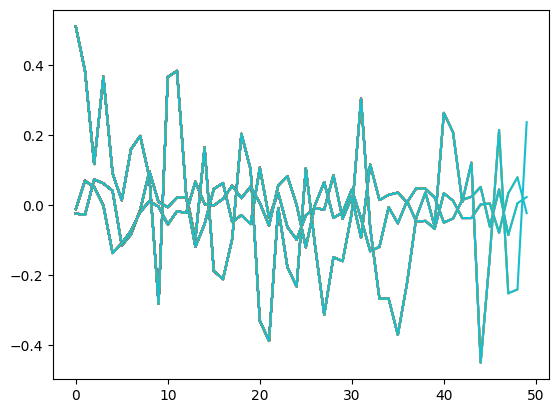

In [7]:

input_size = 7
output_size = 3 
learning_rate = 0.9
discount_factor = 0.99
epsilon = 1.0
epsilon_decay = 0.9995

env = PairTradeEnv(workingPairOutcome, top_keys, validPairsList, return_df)
agent = QLearningAgent(input_size, output_size, learning_rate, discount_factor, epsilon, epsilon_decay)

## Training constants
total_episodes = 50
total_epoch = 3
number_of_pairs = len(workingPairOutcome)
ls_epo_train_reward = []
ls_epo_test_reward = []

for epoch in range(total_epoch):
    ls_epi_reward = []
    for episode in range(total_episodes):
        arr_pair_reward = np.zeros(number_of_pairs)

        for pair_idx in range(number_of_pairs):
            state = env.reset(pair_idx)
            pair_reward = 0
            done = False
            
            while not done:
                action = agent.choose_action(state)
                next_state, reward, done, _ = env.step(action, pair_idx)
                pair_reward += reward
                reward *= 5

                agent.store_experience(state, action, reward, next_state, done)
                agent.learn()
                
                state = next_state

            arr_pair_reward[pair_idx] = pair_reward
        
        total_reward = arr_pair_reward.mean()
        print(f"Episode {episode+1}: Total Return: {total_reward:.3f}, Epsilon: {agent.epsilon:.2f}")
        ls_epi_reward.append(total_reward)

        plt.plot(ls_epi_reward)

    agent.q_network.eval()
    agent.target_network.eval()

    ls_epo_train_reward.append(evaluate_agent_train(agent, env, number_of_pairs))
    ls_epo_test_reward.append(evaluate_agent_test(agent, env, number_of_pairs))

In [8]:
ls_print = [
    input_size,
    output_size,
    learning_rate,
    discount_factor,
    epsilon,
    epsilon_decay,
    total_epoch,
    total_episodes
    ]
for i, p in enumerate(ls_print):
    print(f"{p}")
print(f"Evaluation: Average Total Train Return:{ls_epo_train_reward}")
print(f"Evaluation: Average Total Train Return: mean {np.array(ls_epo_train_reward).mean():.4f}, SD {np.array(ls_epo_train_reward).std():.4f}")
print(f"Evaluation: Average Total Test Return: {ls_epo_test_reward}")
print(f"Evaluation: Average Total Test Return: mean {np.array(ls_epo_test_reward).mean():.4f}, SD {np.array(ls_epo_test_reward).std():.4f}")

7
3
0.9
0.99
1.0
0.9995
3
50
Evaluation: Average Total Train Return:[-0.06490984734068209, 0.09539002653632332, 0.010519322236009676]
Evaluation: Average Total Train Return: mean 0.0137, SD 0.0655
Evaluation: Average Total Test Return: [-0.061122772836067416, 0.09539002653632332, 0.010519322236009676]
Evaluation: Average Total Test Return: mean 0.0149, SD 0.0640


In [9]:

# After training, save the entire Q-network
torch.save(agent.q_network, 'q_network.pth')

### 11 Dec
- revert to **v20241210_0**, verify result is with reward modification
    - **v20241211_0** epsilon update after 2000, modified reward *5 positive / -1 else, update target every 2000 learn occurences ==> ***total reward: 0.44***
- revert to **v20241210_0**, verify result 
    - without reward modification, ensure update network 1000 learn occ. 3 episodes only, epsilon_decay = 0.93 ==> still doing short only
- experimenting with one episode and get the q-values:
    - 1 episode has very even Q value across all actions ==> Q values all 0 (18 mins)
    - 1 episode try with reward shaping max(1,reward*5) positive else -1 ==> all shorting emphasise Short term rewards too much(18 mins)
    - 1 episode try with reward shaping reward*5 if positive else -1 ==> all shorting still
    - 1 episode try with reward shaping reward if positive else -1 to reward ==> all shorting still
    - 1 episode try with reward shaping reward if positive elif <0 -1 to reward ==> all flat
    - 1 episode try with reward shaping 2*reward if positive elif <0 -1 to reward ==> all flat
    - 1 episode try with reward shaping 5*reward if positive elif <0 -1 to reward ==> all flat
    - 1 episode try with reward shaping +1 reward if positive elif <0 -1 to reward ==> all short
- add back spread as one continuous variable for DQN
    - use ***v20241211_1*** architecture except. learning rate: .3, eps decay: 0.9885, episode: 1, learn every 100 occ, 4x4, ADAM, disc factor: .99 ==> Q-values are different! but seems it is too underfit.. mark this as first 7 input version with some fitting. mark this as ***v20241211_2***
    - v20241211_2 but with learning rate: .9 ==> learning rate too high, oscillating for one gradient from 0 to non-zero through training period
    - v20241211_2 but with learning rate: .5 ==> still underfit as both test and train are negative but small returns
    - v20241211_2 to overcome the underfitting in both previous scenarios plan to increase neurons and decrease learning rate.
        - v20241211_2: 8x8 nn ==> overfit
- seems that it is underfit rather than overfit because, it can get the general trend of mean reversion or choose a general model. First try to train more episodes before changing the params. can afford to reduce the eps decay

### 14 Dec
- update workflow to run multiple epoch to auto check consistency. did 10 episodes 2 epochs over 37 mins. not too long. 
- running large batch of 50 episodes 3 epochs to see if SD of the returns can reduce.
- reward also observed to be -.2 to +.2 range. with very high 0 values. must find a way to reduce the peakness. for now *5 the reward


In [10]:
# loaded_q_network = torch.load('q_network_replay1batch_32x4.pth')

# loaded_q_network = QNetwork(6,3)  # Replace QNetwork with your model class
# loaded_q_network.eval()

In [11]:
# Assuming states is a list of 6 states, each a list or NumPy array
states = [[-0.5, 0, 0, 0, 1, 0, 0],
        [-1.5, 0, 0, 0, 1, 1, 0],
        [-2.5, 0, 0, 0, 1, 1, 1],
        [0.5, 0, 0, 1, 0, 0, 0],
        [1.5, 1, 1, 1, 0, 0, 0],
        [2.5, 1, 1, 1, 0, 0, 0]]

# Convert to PyTorch tensor (ensure float32 for compatibility)
states_tensor = torch.tensor(states, dtype=torch.float32)

# Evaluate the Q-values for all states
agent.q_network.eval()  # Set the network to evaluation mode
with torch.no_grad():
    q_values = agent.q_network(states_tensor)  # Output will be a tensor of shape (6, output_size)

# Example: Get the greedy actions for each state
action_indices = torch.argmax(q_values, dim=1).tolist()
actions = [agent.index_to_action[index] for index in action_indices]

print("Q-values:", q_values)
print("Greedy actions:", actions)


Q-values: tensor([[10635.8213, 10496.3545, 10516.8516],
        [10397.9053, 10200.8037, 10308.1006],
        [ 9393.7275,  9115.6816,  9234.6689],
        [ 8551.4268,  9955.6133,  8750.5039],
        [ 7553.3853,  8033.2798,  7586.3022],
        [ 6396.4136,  7261.0469,  6552.6392]])
Greedy actions: [-1, -1, -1, 0, 0, 0]


In [12]:
dict_policy_actions = dict(zip([tuple(state) for state in states], actions))
dict_policy_actions[(0, 0, 0, 0, 0, 0, 0)] = 0
dict_policy_actions

{(-0.5, 0, 0, 0, 1, 0, 0): -1,
 (-1.5, 0, 0, 0, 1, 1, 0): -1,
 (-2.5, 0, 0, 0, 1, 1, 1): -1,
 (0.5, 0, 0, 1, 0, 0, 0): 0,
 (1.5, 1, 1, 1, 0, 0, 0): 0,
 (2.5, 1, 1, 1, 0, 0, 0): 0,
 (0, 0, 0, 0, 0, 0, 0): 0}

### 30 Nov
- first few tries, network is very large
- added epsilon search in "choose_action" functionso that there will be some chance to explore
- changed reward function to multiply losses and give exponential returns to incentivise risk taking

### 1 dec 2105: 
- might have performance is always oscillating negative and positive. This might be because of too large a learning rate. also start from start of training periods max steps to be 3000 so that total results are comparable
    - this helped quite abit. 
    
`
input_size = 7  # Adjust to your specific input size
output_size = 3  # Adjust to your desired number of discrete actions
learning_rate = 0.1
discount_factor = 0.8
epsilon = 1 # down to .3
epsilon_decay = 0.9999
num_episodes = 500
max_steps_per_episode = 3000
`

- want to try changing epsilon to only update after the entire episode instead of after each step. its decaying too quickly
- I want to try with changing reward by changing "learn" to use total_reward instead of "reward"
- Scale the states. need to explore scaling the state since it is still in terms of absolute differences. NN is not able to do proportions
- training epochs should be smaller at up to 30 days because mean reversion pattern is 1 to 33 days
    - very bad performance with 40 day epochs

### 1 dec 2217:
- changed target q value fxn to remove exponential reward and scaled negative reward. now both positive and negative are the same. added portion of total reward in episode to incentivise more long term rewards.
    - `        if reward > 0:
            target_q_value = reward + self.discount_factor * next_q_value * (1 - done) + total_reward * .1
        else:
            target_q_value = reward + self.discount_factor * next_q_value * (1 - done) + total_reward * .1`
    -       `  if episode%1==0:
            agent.epsilon *= agent.epsilon_decay`

### 2 Dec 2101:
- managed to scale but results are not any better
- thinking of reducing learning rate to reduce the oscillations
    - will try to run with learning rate at 0.01
- right now total reward is taking all of the target q function. maybe can make it a 50/50 split

### 3 dec
- training taking 
    - a full length training dataset.
    - 1000 per learning step
    - learning rate test (1.5 mins per episode)
        - episodes: 5
        - learning rate: 0.05 ==> total reward: .037
        - learning rate: 0.5 ==> total reward: -.6
        - learning rate: 0.3 ==> total reward: 0.88, .044
        - learning rate: 0.15 ==> total reward: -.023
        - learning rate: 0.25 ==> total reward: -.6
        - learning rate: 0.35 ==> total reward: .028
    - with drop out layer test (1.75 mins per episode)
        - learning rate: 0.3 ==> total reward: -0.488
        - learning rate: 0.4 ==> total reward: -0.422
        - learning rate: 0.5 ==> total reward: .26, .13, .096
        - learning rate: 0.6 ==> total reward: .03
        - learning rate: 0.7 ==> total reward: -.08
- performance still bad. should include dropout layer? --> performance a bit worse but more consistent
- try removing spread so that the input is only boolean of SD and last position
    - drop out layer test (1.75 mins per episode)
        - learning rate: 0.1 ==> total reward: -.36
        - learning rate: 0.3 ==> total reward: -.01
        - learning rate: 0.5 ==> total reward: -.26
### 5 dec
- previously target and online network updated at the same time, but it should be used to regularise. So will try with updating more periodically instead of every learn step. reduced NN to 16 and 8 hidden layers with dropout (1.67 min per episode)
    - learning rate: 0.3, update target every 10 learn occurences ==> total reward: .03
    - learning rate: 0.3, update target every 100 learn occurences ==> total reward: .26
    - learning rate: 0.3, update target every 500 learn occurences ==> total reward: -.383
    - learning rate: 0.3, update target every 600 learn occurences ==> total reward: .22
    - learning rate: 0.3, update target every 675 learn occurences ==> total reward: .41
    - learning rate: 0.3, update target every 700 learn occurences ==> total reward: .10, .03
    - learning rate: 0.3, update target every 750 learn occurences ==> total reward: .40, .15, -0.353
    - learning rate: 0.3, update target every 1000 learn occurences ==> total reward: .05
    - learning rate: 0.3, update target every 10 learn occurences, remove dropout layers ==> total reward: -.203
    - learning rate: 0.5, update target every 10 learn occurences, remove dropout layers ==> total reward: -.334
- changed ADAM optimiser to SGD (1.6 min per episode)
    - learning rate: 0.15, update target every 750 learn occurences ==> total reward: .084
    - learning rate: 0.3, update target every 750 learn occurences ==> total reward: -.20
    - learning rate: 0.5, update target every 750 learn occurences ==> total reward: .303
    - learning rate: 0.6, update target every 750 learn occurences ==> total reward: -.110
    - learning rate: 0.7, update target every 750 learn occurences ==> total reward: -.556, -0.449
- long term run with 50 episodes
    - SGD, learning rate: 0.5, update target every 750 learn occurences ==> total reward: -.04 (79 min)
    - ADAM, learning rate: 0.3, update target every 750 learn occurences ==> total reward: -.01 (84.5 min)
    - ADAM, 32 hidden layer, learning rate: 0.3, update target every 750 learn occurences ==> total reward: 0.54 (88 min)
- long term run with 300 episodes
    - ADAM, 32X16 hidden layer, learning rate: 0.3, update target every 750 learn occurences ==> total reward:  -0.28(540 min)
### 6 Dec
1. reduce to only 4 SD flags - Done
2. discount factor up to .99 - Done
3. try increasing punishment with X10 negative reward if less than 0 - Done

- there is a positive gradient
    - 5 episodes, X10 negative reward ADAM, 32X16 hidden layer, learning rate: 0.3, update target every 750 learn occurences ==> total reward: .05
    - 5 episodes, X10 negative reward ADAM, 32X8 hidden layer, learning rate: 0.3, update target every 750 learn occurences ==> total reward: -0.01
    - 5 episodes, X100 negative reward ADAM, 32X16 hidden layer, learning rate: 0.3, update target every 750 learn occurences ==> total reward: -0.01 (8 mins)
    - 5 episodes, X100 negative reward ADAM, 32X16 hidden layer, learning rate: 0.3, update target every 750 learn occurences ==> total reward: 0.014
    - 300 episodes, X100 negative reward ADAM, 32X16 hidden layer, learning rate: 0.3, update target every 750 learn occurences ==> total reward: 0.017
    - 50 episodes, X100 negative reward ADAM, 32X16 hidden layer, learning rate: 0.3, update target every 750 learn occurences, discount_factor = 0.99 ==> total reward: 
- try reducing net to only 4 neurons
    - 5 episodes, X100 negative reward ADAM, 4X4 hidden layer, learning rate: 0.3, update target every 750 learn occurences ==> total reward: 0.0
    - 10 episodes, X100 negative reward ADAM, 4X4 hidden layer, learning rate: 0.3, update target every 750 learn occurences ==> total reward: 0.0
### 8 Dec 
- 50 episodes, X100 negative reward ADAM, 4X4 hidden layer, learning rate: 0.3, update target every 750 learn occurences, discount_factor = 0.99 ==> total reward: 0.118
- 300 episodes, X100 negative reward ADAM, 4X4 hidden layer, learning rate: 0.3, update target every 750 learn occurences, discount_factor = 0.99 ==> total reward: -0.02 (epsilon 10), 0.29 (epsilon .46)
- try removing previous action in state space to move to 4 state spaces only . 4X4
    - 4X4, 10 episodes, X100 negative reward ADAM, 4X4 hidden layer, learning rate: 0.3, update target every 750 learn occurences, discount_factor = 0.99 ==> total reward: 0.282
    - 4X4, epsilon_decay = 0.955, 20 episodes, X100 negative reward ADAM, learning rate: 0.3, update target every 750 learn occurences, discount_factor = 0.99 ==> total reward: -.20
    - 4X4, epsilon_decay = 0.9885, 20 episodes, X100 negative reward ADAM, learning rate: 0.3, update target every 750 learn occurences, discount_factor = 0.99 ==> total reward: 0.08
    - 32X4, epsilon_decay = 0.9885, 20 episodes, X100 negative reward ADAM, learning rate: 0.3, update target every 750 learn occurences, discount_factor = 0.99 ==> total reward: 0.07
    - add back dropout layers, 32X4, epsilon_decay = 0.9885, 20 episodes, X100 negative reward ADAM, learning rate: 0.3, update target every 750 learn occurences, discount_factor = 0.99 ==> total reward: .21
    - add back dropout layers, 32X4, epsilon_decay = 0.9885, 10 episodes, X100 negative reward ADAM, learning rate: 0.3, update target every 750 learn occurences, discount_factor = 0.5 ==> total reward: .002
    - add back dropout layers, 32X4, epsilon_decay = 0.9885, 10 episodes, X100 negative reward ADAM, learning rate: 0.3, update target every 750 learn occurences, discount_factor = 0.5 ==> total reward: .002
    - add back dropout layers, 32X4, epsilon_decay = 0.9885, 300 episodes, X100 negative reward ADAM, learning rate: 0.3, update target every 750 learn occurences, discount_factor = 0.99 ==> total reward: 0.115
### 9 Dec
- state cases should be imbalanced
    - add back dropout layers, 32X4, epsilon_decay = 0.9885, 20 episodes,  ADAM, learning rate: 0.3, update target every 1000 learn occurences, discount_factor = 0.99 ==> total reward: -0.29
    - add back dropout layers, 32X4, epsilon_decay = 0.9885, 5 episodes,  ADAM, learning rate: 0.3, update target every 1000 learn occurences, discount_factor = 0.99 ==> total reward: 0.223
    - add back dropout layers, 32X4, epsilon_decay = 0.9885, 5 episodes, ADAM, learning rate: 0.3, update target every 550 learn occurences, discount_factor = 0.99 ==> total reward: 0.126
    - add back dropout layers, 32X4, epsilon_decay = 0.9885, 10 episodes,  ADAM, learning rate: 0.3, update target every 550 learn occurences, discount_factor = 0.99 ==> total reward: 
- changed data set to 17 pairs
    - add back dropout layers, 32X4, epsilon_decay = 0.9885, 10 episodes,  ADAM, learning rate: 0.3, update target every 550 learn occurences, discount_factor = 0.99 ==> total reward: -0.16
    - 17 pairs, add back dropout layers, 32X4, epsilon_decay = 0.9885, 5 episodes,  ADAM, learning rate: 0.3, update target every 550 learn occurences, discount_factor = 0.99, changed reward *5 for positive, -1 for negative ==> total reward:0.06 (at least got positive gradient), try run again to get more data on consistency. also need to observe if exploiting might be necessary
    - 17 pairs, add back dropout layers, 32X4, epsilon_decay = 0.9885, 5 episodes,  ADAM, learning rate: 0.3, update target every 550 learn occurences, discount_factor = 0.99, changed reward *5 for positive, -1 for negative ==> total reward:0.087 

### 10 Dec
- changed data set to 17 pairs
    - 17 pairs, add back dropout layers, 32X4, epsilon_decay = 0.9885, 10 episodes,  ADAM, learning rate: 0.3, update target every 550 learn occurences, discount_factor = 0.99, changed reward *5 for positive, -1 for negative ==> total reward:-0.10 
- no need for complicated network, reduce to 8 (5 min per ep)
    - 17 pairs, add back dropout layers, 8X4, epsilon_decay = 0.9885, 5 episodes,  ADAM, learning rate: 0.3, update target every 550 learn occurences, discount_factor = 0.99, changed reward *5 for positive, -1 for negative ==> total reward: -0.113
- try removing dropout layers
    - 17 pairs, add back dropout layers, 8X4, epsilon_decay = 0.9885, 5 episodes,  ADAM, learning rate: 0.3, update target every 550 learn occurences, discount_factor = 0.99, changed reward *5 for positive, -1 for negative ==> total reward: 0.04
- replay above 20241209 good result
    - **v20241210_0** add back dropout layers, 32X4, epsilon_decay = 0.9885, 5 episodes,  ADAM, learning rate: 0.3, update target every 1000 learn occurences, discount_factor = 0.99 ==> total reward: 0.33 (20 min per episode)
    - add back dropout layers, 32X4, epsilon_decay = 0.9885, 10 episodes,  ADAM, learning rate: 0.3, update target every 1000 learn occurences, discount_factor = 0.99 ==> total reward: 0.082 at episode 5, 0.195 at episode 10 (18.5 mins per episode)
- Think need to update the target network more frequently. might be missing the learnings from the policy network.
    - add back dropout layers, 32X4, epsilon_decay = 0.9885, 30 episodes,  ADAM, learning rate: 0.3, update target every 50 learn occurences, discount_factor = 0.99 ==> total reward: -.11 after 28 episodes (18.5 mins per sepisode)-0.04 after 5 episodes